6/14/20 This notebook has two parts. (last executed under 2020_11)

### Part I. We calculate m5 using standard syseng_throughput inputs. 
### Part II. We take the median m5 from the per-amp calculation results and estimate our final fS.

#### Part I.

Since we are not tracking m5 by amplifer yet, we need a effective diameter for calculating the area-weighted m5 over the entire field.

Below we first look at the vignetting function, V(r) - unvignetted area as a function of field radius.
Note that we normalize V(r=0) to be 1. Use A for area,

A = A(r=0)* V(r)

So,

D = D(r=0) * sqrt(V(r))

Then we calculate the area-weighted D, which is our effective diameter over the field, D_eff.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
# read the Excel file, and write the vignetting function to txt. Only needs to be done once.

vfile0 = '../data/vignettingF_doc7512.txt'
if not os.path.isfile(vfile0):
    ExcelFromChuck = '../documentation/EtendueCalculator.xls'
    df = pd.read_excel(ExcelFromChuck, sheet_name='Sheet1',skiprows=3) 
    outerR = np.float64(df['Field Annulus Outer Radius'][1:])
    vigR = np.float64(df['Optical Throughput (from Zemax Vigneting Analysis)'][1:])

    #get rid of the zeros and NaNs
    idx = ~np.isnan(outerR)
    outerR = outerR[idx]
    outerVig = vigR[idx]

    print('Writing to file %s' % vfile0)

    header = '#field radius(deg)   vignetting ratio(0-1)'
    with open(vfile, 'w') as f:
        print(header, file=f)
        for i in range(len(outerR)):
            print(outerR[i], outerVig[i], file=f)

In [3]:
#vignettingF_doc7512.txt doesn't have field points with radius>1.8; 
# also, the values seem a bit different from what I get using v3.3 and v3.11 Zemax models, 
# raytracing 10,000 rays at each field.
# below we use v3.11 values
vfile = '../data/vignettingF.txt'
M1D = 8.36 #clear aperture as in Optical design v3.3
aa = np.loadtxt(vfile, skiprows=12)
r = aa[:,0]
v = aa[:,1]
v0 = v[0]
D0 = (M1D)*np.sqrt(v0)
v = v/v0

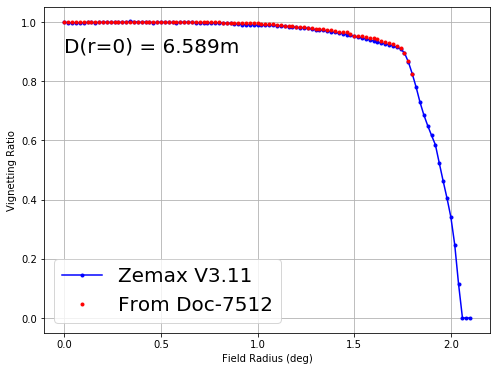

In [4]:
fig1 = plt.figure(figsize=(8, 6))
plt.plot(r, v,'-b.', label='Zemax V3.11')
plt.grid()
plt.xlabel('Field Radius (deg)')
plt.ylabel('Vignetting Ratio')
plt.text(0, .9, 'D(r=0) = %.3fm'%D0, {'fontsize':20})

aa = np.loadtxt(vfile0, skiprows=1)
plt.plot(aa[:,0], aa[:,1]/aa[0,1], 'r.', label='From Doc-7512')
plt.legend(fontsize = 20)

In [5]:
# there has been some inconsistencies in the numbers we've been quoting so far(?)
print('our baseline above (Zemax model v3.11)')
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(D0, v0))
M1A = np.pi*((8.36/2)**2 - 2.558**2)
print('using optical design parameters')
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(np.sqrt(M1A/np.pi)*2, M1A/(np.pi*(8.36/2)**2) ))
# using values from Document-7512,
#(note that a number of things including hexapods have been adjusted for IQ optimization.)
aa = np.loadtxt(vfile0, skiprows=1)
print('using document-7512 numbers')
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(8.406*np.sqrt(aa[0,1]), aa[0,1]))
print('using old LSE-11 numbers (2012 version - 649 rays per field)')
v00 = 0.610169
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(np.sqrt(M1A/np.pi)*2, v00))
print('using Zemax model v3.3')
v00 = 0.624092
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%((M1D)*np.sqrt(v00), v00))
print('SRD Appendix A:')
print('\t\t\t D0 = 6.68m')

our baseline above (Zemax model v3.11)
			 D0 = 6.59m, unnormalized V(r=0) = 0.621
using optical design parameters
			 D0 = 6.61m, unnormalized V(r=0) = 0.626
using document-7512 numbers
			 D0 = 6.58m, unnormalized V(r=0) = 0.612
using old LSE-11 numbers (2012 version - 649 rays per field)
			 D0 = 6.61m, unnormalized V(r=0) = 0.610
using Zemax model v3.3
			 D0 = 6.60m, unnormalized V(r=0) = 0.624
SRD Appendix A:
			 D0 = 6.68m


put down a dense grid and check what fraction of the points land on chips

In [6]:
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import chipNameFromRaDec
from lsst.sims.utils import ObservationMetaData
from lsst.sims.utils import angularSeparation

In [7]:
mapper = LsstSimMapper()
epoch=2000.
ra, dec = np.meshgrid(np.linspace(-2.1,2.1, 525), np.linspace(-2.1,2.1, 525))
obs_metadata = ObservationMetaData(pointingRA=np.degrees(0.),
                                                   pointingDec=np.degrees(0.),
                                                   rotSkyPos=np.degrees(0.),
                                                   mjd=53000)

In [8]:
chipNames = chipNameFromRaDec(ra.ravel(),dec.ravel(),epoch=epoch, camera=mapper.camera, obs_metadata=obs_metadata)

In [9]:
radius = angularSeparation(0., 0., ra.ravel(), dec.ravel())
v2d = np.interp(radius, r, v)

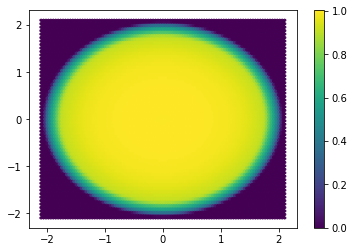

In [10]:
plt.hexbin(ra.ravel(), dec.ravel(), v2d)
plt.colorbar()

In [11]:
good = np.where((chipNames != [None]))
# Check for other bits
cng = np.array(chipNames[good], dtype='str')
find_char1 = np.char.find(cng, 'R:0,0')
find_char2 = np.char.find(cng, 'R:4,4')
find_char3 = np.char.find(cng, 'R:4,0')
find_char4 = np.char.find(cng, 'R:0,4')

good2 = np.where((find_char1 == -1) & (find_char2 == -1)
                & (find_char3 == -1) & (find_char4 == -1))
good = good[0][good2]
bad = np.where(chipNames == [None])

(-2.3159139784946237,
 2.3159139784946237,
 -2.3175883002207507,
 2.3175883002207507)

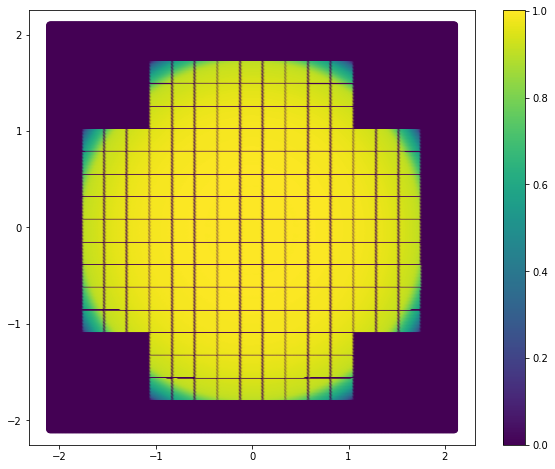

In [12]:
plt.figure(figsize=(10, 8))
ack = ra.ravel()*0
ack[good] = 1
plt.scatter(ra.ravel(), dec.ravel(), c= v2d*ack)
#plt.hexbin(ra.ravel(), dec.ravel(), v2d*ack, gridsize=500)
plt.colorbar()
plt.axis('equal')
#plt.xlim([-0.5, 0.5])
#plt.ylim([-0.5, 0.5])

In [13]:
Deff = D0*np.mean(np.sqrt(v2d[good]))
print('the effective D= %.3fm'%(Deff))

the effective D= 6.404m


Now, to calculate m5, we need the syseng_throughput repo

In [14]:
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import Bandpass
from lsst.utils import getPackageDir

In [15]:
masterdir = getPackageDir('syseng_throughputs')
masterDirs = st.setDefaultDirs(rootDir=masterdir)
master_hardware, master_system = st.buildHardwareAndSystem(masterDirs)

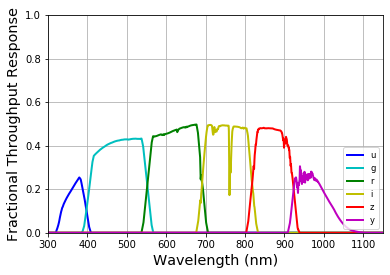

In [16]:
st.plotBandpasses(master_system, addlegend=True)

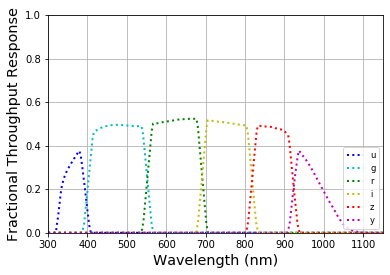

In [17]:
st.plotBandpasses(master_hardware, linestyle=':', addlegend=True)

In [18]:
master_m5 = st.makeM5(master_hardware, master_system, darksky=None, 
                      exptime=15, nexp=2, readnoise=8.8, othernoise=0, darkcurrent=0.2,
                      effarea=np.pi*(Deff/2*100)**2, X=1.0)

In [19]:
master_m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.368814,27.002827,0.035837,0.057997,0.522669,0.038183,23.160278,0.578244,0.364504,23.843919,550.407595,23.9,23.4
g,0.87,0.76714,22.257758,408.695779,28.392934,0.128938,0.154358,0.195371,0.038741,24.443381,0.177054,0.093565,24.836207,793.984797,25.0,24.6
r,0.83,0.73426,21.196590,814.018911,28.171053,0.105106,0.115690,0.104170,0.038988,24.463776,0.096593,0.048002,24.377121,987.856797,24.7,24.3
i,0.80,0.70960,20.477419,1166.639706,27.873201,0.079889,0.085493,0.073607,0.039099,24.359452,0.069305,0.033319,23.953181,1109.505065,24.0,23.6
z,0.78,0.69316,19.599578,1772.587419,27.475450,0.055384,0.057871,0.047694,0.039233,24.198359,0.046695,0.021578,23.380656,1303.283361,23.3,22.9
y,0.76,0.67672,18.610405,2357.186840,26.681146,0.026648,0.030944,0.162291,0.039309,23.756286,0.035524,0.015903,22.472200,1447.770147,22.1,21.7


In [20]:
m5 = np.array(master_m5.m5)

In [21]:
# the 0th order calculation Bo has been showing at summer 2018 reviews:
m5SRD = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1])
#m5SRDmin = []
#m5 = np.array([23.78, 24.81, 24.35, 23.92, 23.34, 22.45])
# Nv1 from SRD table 24
Nv1 = np.array([56, 80, 184, 184, 160, 160])
omega = Nv1/sum(Nv1)
fS = sum(omega*10**(0.8*(m5 - m5SRD)))
print('Current estimate: fS = %.2f'%fS)

Current estimate: fS = 1.07


In [22]:
#how much change do we expect when D_eff goes from 6.423 to 6.404?
print('%.3f'%(6.401/6.423)**2)

0.993


#### Part II.

In [3]:
dfPath = os.path.join('m5_by_amp/m5_output', 'm5_master_db.csv')
mdf = pd.read_csv(dfPath, index_col=0)

In [4]:
m5filter = []
filters = ['u', 'g', 'r', 'i', 'z', 'y']
for f in filters:
    idx = mdf['m5_%s'%f]>0
    idx1 = (mdf['m5_%s'%f]>0) & (mdf['vendor'] == 'ITL')
    idx2 = (mdf['m5_%s'%f]>0) & (mdf['vendor'] == 'E2V')
    a = sum(idx)
    a1=sum(idx1)
    a2=sum(idx2)
    idx1 = (mdf['m5_%s'%f]>-100) & (mdf['vendor'] == 'ITL')
    idx2 = (mdf['m5_%s'%f]>-100) & (mdf['vendor'] == 'E2V')    
    b = sum(mdf['m5_%s'%f]>-100)
    b1=sum(idx1)
    b2=sum(idx2)
    c = np.median(mdf['m5_%s'%f])
    d = np.median(mdf.loc[idx, 'm5_%s'%f])
    print('%s, good/total amp = %.0f/%.0f, ITL good = %.4f, E2V good = %.4f, m5 median total = %.3f, m5 median good= %.3f'%(
        f, a,b, a1/b1, a2/b2, c, d))
    m5filter.append(d)
m5filter = np.array(m5filter)

u, good/total amp = 3022/3024, ITL good = 0.9991, E2V good = 0.9995, m5 median total = 24.166, m5 median good= 24.167
g, good/total amp = 3022/3024, ITL good = 0.9991, E2V good = 0.9995, m5 median total = 24.952, m5 median good= 24.952
r, good/total amp = 3022/3024, ITL good = 0.9991, E2V good = 0.9995, m5 median total = 24.471, m5 median good= 24.471
i, good/total amp = 3022/3024, ITL good = 0.9991, E2V good = 0.9995, m5 median total = 24.003, m5 median good= 24.004
z, good/total amp = 3022/3024, ITL good = 0.9991, E2V good = 0.9995, m5 median total = 23.408, m5 median good= 23.408
y, good/total amp = 3022/3024, ITL good = 0.9991, E2V good = 0.9995, m5 median total = 22.467, m5 median good= 22.467


In [5]:
m5SRD = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1])
m5SRDmin =       [23.4, 24.6, 24.3, 23.6, 22.9, 21.7]
# Nv1 from SRD table 24
Nv1 = np.array([56, 80, 184, 184, 160, 160])
omega = Nv1/sum(Nv1)

fSamp = []
for i in mdf.index:
    m5amp = np.array([mdf.loc[i, 'm5_%s'%f] for f in filters])
    if np.all(m5amp>0):
        fS = sum(omega*10**(0.8*(m5amp - m5SRD)))
        fSamp.append(fS)
print(len(fSamp))

3022


In [6]:
print('Current estimate (average over all amps): fS = %.2f'%np.mean(fSamp))
print('median over all amps: fS = %.2f'%np.median(fSamp))

Current estimate (average over all amps): fS = 1.15
median over all amps: fS = 1.19


In [7]:
sum(omega*10**(0.8*(m5SRD-m5SRDmin)))

2.118015860024805

In [8]:
18000/15000*825/750

1.32

In [46]:
#field center values
#these are already truncated to %.3f in the master db file (but not db files for individual rafts)
a = {}
for f in filters:
    a[f] = np.round(mdf['m5_%s'%f]['R22_S11_C04'],3)
print('centerV = ', a)
c = []
for f in filters:
    b = mdf['m5_%s'%f].copy()
    b[b<0] = a[f]
    c.append(max(b)-a[f])
    c.append(min(b)-a[f])
print(max(c), min(c))
print(max([max(mdf['m5_%s'%f] - a[f]) for f in filters]))
print(min([min(mdf['m5_%s'%f] - a[f]) for f in filters]))

for f in filters:
    a[f] = np.round(mdf['T%s'%f]['R22_S11_C04'],3)
print('centerV = ', a)

for f in filters:
    a[f] = np.round(mdf['S%s'%f]['R22_S11_C04'],3)
print('centerV = ', a)

centerV =  {'u': 24.238, 'g': 24.987, 'r': 24.503, 'i': 24.031, 'z': 23.428, 'y': 22.469}
0.1579999999999977 -6.015000000000001
0.1579999999999977
-6.015000000000001
centerV =  {'u': 0.039, 'g': 0.134, 'r': 0.114, 'i': 0.082, 'z': 0.055, 'y': 0.024}
centerV =  {'u': 0.062, 'g': 0.163, 'r': 0.128, 'i': 0.09, 'z': 0.059, 'y': 0.028}


In [44]:
min(b)

18.182000000000002